# Signal check: r941 fast basecalling

> comparing workflows for viral genome assembly from minion amplicon-based sequencing

***

## Overview

* download the data
    - 3 Ebola virus (EBOV) samples
    - multiplexed on one flowcell
    - already basecalled using Guppy (r941 fast mode)

* assemble the samples using the de novo pipeline
    - demux and trim the basecalled reads
    - assemble (miniasm / redbean)
    - correct the assemblies (racon x4 iterations)
    - polish, either:
        - without signal (medaka)
        - with signal (nanopolish)
        - with signal and without (nanopolish then medaka)

* assess all the de novo assemblies for each sample
    - stats (quast)
    - find closest reference matches in refseq (fastani)
    - check nucleotide and structural differences (nucdiff)
   
* assemble the samples using the reference guided pipeline
    - select appropriate reference from refseq using the de novo assembly
    - assemble with rebaler

* assess all the reference guided assemblies for each sample
    - stats (quast)
    - check nucleotide and structural differences (nucdiff)


## 1. Download the data

* download the complete ebola genomes from RefSeq

In [1]:
!ncbi-genome-download --format fasta --assembly-level complete --fuzzy-genus --genus ebola viral -o tmp

* download the Ebola virus Nanopore data from the [artic data releases](http://artic.network/protocol_validation_2019.html)
    * we are using the Ebola virus (EBOV) minion run that amplicon sequenced 3 strains of the virus (Mayinga, Kikwit, Makona) using the rapid PCR kit

In [2]:
!wget http://artic.s3.climb.ac.uk/run-folders/EBOV_Metagenomics.tar.gz --directory-prefix=tmp/
!tar -xvf tmp/EBOV_Metagenomics.tar.gz -C tmp/ --strip-components=1

--2019-10-03 09:12:33--  http://artic.s3.climb.ac.uk/run-folders/EBOV_Metagenomics.tar.gz
Resolving artic.s3.climb.ac.uk (artic.s3.climb.ac.uk)... 137.205.52.6
Connecting to artic.s3.climb.ac.uk (artic.s3.climb.ac.uk)|137.205.52.6|:80... connected.
HTTP request sent, awaiting response... 
  HTTP/1.1 200 OK
  Server: nginx/1.14.0
  Date: Thu, 03 Oct 2019 08:12:34 GMT
  Content-Type: application/gzip
  Content-Length: 1070346070
  Connection: keep-alive
  Accept-Ranges: bytes
  Last-Modified: Tue, 03 Sep 2019 15:29:47 GMT
  ETag: "6e2449545dc6d1ac030505b880132e29-8"
  x-amz-meta-s3cmd-attrs: atime:1567522299/ctime:1567522360/gid:1000/gname:artic/md5:eb30cd588722793c39455ceb97898874/mode:33188/mtime:1567522310/uid:1000/uname:artic
  x-amz-request-id: tx0000000000000000148af-005d95ad71-358ae44f-s3-warwick
Length: 1070346070 (1021M) [application/gzip]
Saving to: ‘tmp/EBOV_Metagenomics.tar.gz’

EBOV_Metagenomics.t 100%[===================>]   1021M  2.67MB/s    in 6m 45s  

2019-10-03 09:19:

## 2. Assemble the samples using the de novo pipeline

The library that we just downloaded contains 3 barcoded samples - we want barcodes 9, 10 and 11 (9=Mayinga,10=Kikwit,11=Makona)

* run the de-novo assembly pipeline
    * this will assemble, correct and polish the 3 samples
    * **note**: this takes around 20 minutes using the settings below
    * **note**: make sure you have docker installed and the daemon is running!

In [3]:
!nextflow run pipelines/long-read-assembly-dn.nf \
    -profile docker \
    --cpus 6 \
    --mem 14GB \
    --inputDir $PWD/tmp \
    --barcodes 09,10,11 \
    --output pipelines/data/ebov-dn-assemblies \
    --assembler miniasm \
    --subSamplingDepth 100

N E X T F L O W  ~  version 19.07.0
Launching `pipelines/long-read-assembly.nf` [astonishing_euclid] - revision: a28a147a80
-------------------------------------------------------
long read assembly pipeline v0.1
-------------------------------------------------------
Input dir      : /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp
Barcodes       : 09,10,11
Sequencing kit : Auto
Sampling depth : 100
Racon iterat.  : 4
Medaka model   : r941_min_fast
Output dir     : pipelines/data/ebov-assemblies
Working dir    : /Users/willrowe/Desktop/nanoporeSignal/signal-check/work
Max. memory    : 14GB
Max. CPUs      : 6
Profile        : docker
Current home   : /Users/willrowe
Current user   : willrowe
Current path   : /Users/willrowe/Desktop/nanoporeSignal/signal-check
Script dir     : /Users/willrowe/Desktop/nanoporeSignal/signal-check/pipelines
-------------------------------------------------------
[-        ] process > demuxingReads               -
[-        ] process > assemblingReads


executor >  local (13)
[ff/865e32] process > demuxingReads                  [100%] 1 of 1 ✔
[cd/48a7a9] process > assemblingReads (2)            [100%] 3 of 3 ✔
[5b/eb49b6] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[1b/7c765b] process > polishingWithMedaka (3)        [100%] 3 of 3 ✔
[92/c00373] process > subsamplingReads (3)           [ 67%] 2 of 3
[-        ] process > polishingWithNanopolish        -
[-        ] process > repolishingWithMedaka          -
[-        ] process > assessAssemblies               -
[info] subsampling reads for barcode-09, using barcode-09.fastq and barcode-09.assembly-corrected.fasta


executor >  local (14)
[ff/865e32] process > demuxingReads                  [100%] 1 of 1 ✔
[cd/48a7a9] process > assemblingReads (2)            [100%] 3 of 3 ✔
[5b/eb49b6] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[1b/7c765b] process > polishingWithMedaka (3)        [100%] 3 of 3 ✔
[92/c00373] process > subsamplingReads (3)           [100%] 3 o

## 3. Assess all the de novo assemblies for each sample

* compare the assemblies to the Ebola reference genomes

In [13]:
# get a file list of all the viral genomes we downloaded
!find $PWD/tmp/refseq/viral/GCF_00*/*.gz > tmp/ref-genome-list.txt

# get a file list of all the assemblies we just made
!find $PWD/pipelines/data/ebov-dn-assemblies/*.fasta > tmp/assembled-genome-list.txt

# run fastani to compute Average Nucleotide Identity
!fastani --ql tmp/assembled-genome-list.txt --rl tmp/ref-genome-list.txt -o tmp/fastani-out.tab --fragLen 100 --matrix

>>>>>>>>>>>>>>>>>>
Reference = [/Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/refseq/viral/GCF_000848505.1/GCF_000848505.1_ViralProj14703_genomic.fna.gz, /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/refseq/viral/GCF_000854085.1/GCF_000854085.1_ViralProj15006_genomic.fna.gz, /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/refseq/viral/GCF_000855585.1/GCF_000855585.1_ViralProj15012_genomic.fna.gz, /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/refseq/viral/GCF_000888475.1/GCF_000888475.1_ViralProj51257_genomic.fna.gz, /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/refseq/viral/GCF_000889155.1/GCF_000889155.1_ViralProj51245_genomic.fna.gz, /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/refseq/viral/GCF_003505815.1/GCF_003505815.1_ASM350581v1_genomic.fna.gz]
Query = [/Users/willrowe/Desktop/nanoporeSignal/signal-check/pipelines/data/ebov-dn-assemblies/barcode-09.assembly-corrected.medaka-polished.fasta, /Users/willrowe/Desktop/nanopor

In [14]:
# plot the pairwise ANI scores as a heatmap
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)

# convert triangular matrix to a regular one (https://github.com/marbl/Mash/issues/9#issuecomment-509837201)
def lower_triangle_to_full_matrix(filename):
    num_lines_in_file = sum(1 for line in open(filename))
    distances = []
    sample_names = []

    with open(filename) as f:
        next(f) # skip sample count line
        for line in f:
            elements = line.strip().split('\t')
            for i, e in enumerate(elements):
                if e == 'NA':
                    elements[i] = 0.0
            elements[0] = os.path.basename(elements[0])
            sample_names.append(elements[0])
            row = [float(e) for e in elements[1:]]
            row.extend([0.0] * (num_lines_in_file-1-len(row)))
            distances.append(row)
        np_array = np.asarray(distances)
        index_upper = np.triu_indices(num_lines_in_file-1)
        np_array[index_upper] = np_array.T[index_upper]
        return pd.DataFrame(np_array, columns=sample_names, index=sample_names)

df = lower_triangle_to_full_matrix('tmp/fastani-out.tab.matrix')

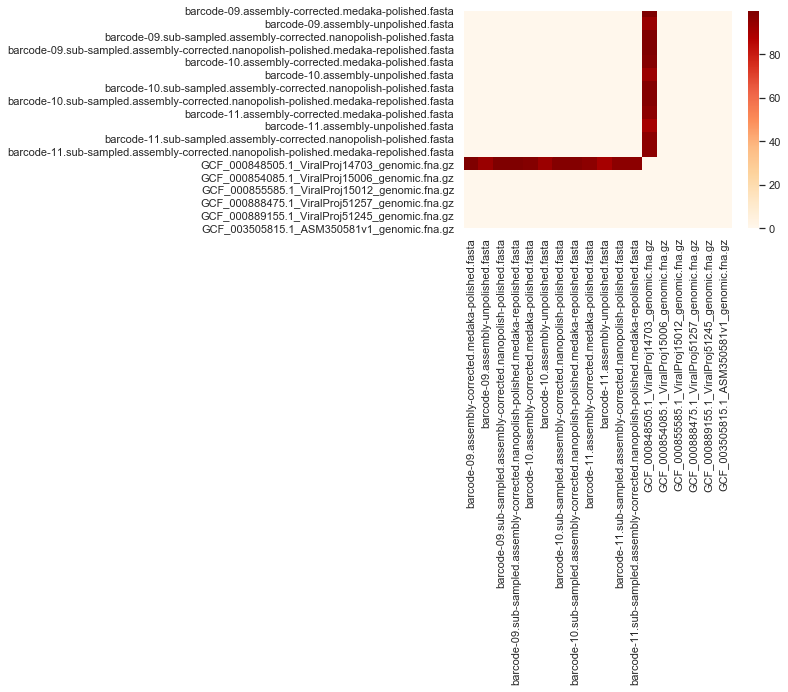

In [15]:
# make the plot
sns.heatmap(df, cmap="OrRd")

> the closest reference genome is `GCF_000848505.1_ViralProj14703_genomic.fna.gz` (which is Mayinga)


### Mayinga

* compare each Mayinga assembly to this reference genome

In [16]:
!find ./ -name GCF_000848505.1_ViralProj14703_genomic.fna.gz -exec gunzip -c {} + > tmp/ref-genome.fasta
!nucdiff tmp/ref-genome.fasta pipelines/data/ebov-dn-assemblies/barcode-09.assembly-unpolished.fasta tmp/nucdiff-out unpolished
!nucdiff tmp/ref-genome.fasta pipelines/data/ebov-dn-assemblies/barcode-09.assembly-corrected.medaka-polished.fasta tmp/nucdiff-out polished-with-signal
!nucdiff tmp/ref-genome.fasta pipelines/data/ebov-dn-assemblies/barcode-09.sub-sampled.assembly-corrected.nanopolish-polished.fasta tmp/nucdiff-out polished-without-signal
!nucdiff tmp/ref-genome.fasta pipelines/data/ebov-dn-assemblies/barcode-09.sub-sampled.assembly-corrected.nanopolish-polished.medaka-repolished.fasta tmp/nucdiff-out polished-with-both


Run NUCmer...

1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/nucdiff-out/unpolished.ntref" of length 18960
# construct suffix tree for sequence of length 18960
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# CONSTRUCTIONTIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/nucdiff-out/unpolished.ntref 0.00
# reading input file "/Users/willrowe/Desktop/nanoporeSignal/signal-check/pipelines/data/ebov-dn-assemblies/barcode-09.assembly-unpolished.fasta" of length 18634
# matching query-file "/Users/willrowe/Desktop/nanoporeSignal/signal-check/pipelines/data/ebov-dn-assemblies/barcode-09.assembly-unpolished.fasta"
# against subject-file "/Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/nucdiff-out/unpolished.ntref"
# COMPLETETIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/


Find differences...

The difference detection inside fragments step is complete

The difference detection between fragments step is complete

Run NUCmer...

1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/nucdiff-out/polished-with-both.ntref" of length 18960
# construct suffix tree for sequence of length 18960
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# CONSTRUCTIONTIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/nucdiff-out/polished-with-both.ntref 0.00
# reading input file "/Users/willrowe/Desktop/nanoporeSignal/signal-check/pipelines/data/ebov-dn-assemblies/barcode-09.sub-sampled.assembly-corrected.nanopolish-polished.medaka-repolished.fasta" of length 18915
# matching query-file "/Users/willrowe/Desktop/nanoporeSignal/signal-check/pipelines/data/ebov-dn-assemblies/barcode-09.sub-sample

In [17]:
# nucdiff will report SNPs, InDels and rearrangements, as well as the breadth of coverage, compared to the reference
import glob

nucdiffFiles = [i for i in glob.glob('tmp/nucdiff-out/results/*.out')]

dfs = []
for f in nucdiffFiles:
    fn = os.path.basename(f).replace('_stat.out', '')
    df = pd.read_csv(f, sep='\t', header=None, index_col=0)
    df.columns = [fn]
    dfs.append(df)
combined = pd.concat(dfs, axis=1, sort=False)

print("\nMayinga assemblies compared to the RefSeq Mayinga genome:\n\n")

print(combined.loc[ ['Total number', 'Insertions', 'Deletions', 'Substitutions'] , : ])

print(combined.loc[ ['Uncovered ref regions num', 'Uncovered ref regions len'] , : ])


Mayinga assemblies compared to the RefSeq Mayinga genome:


               polished-with-signal  polished-without-signal  \
0                                                              
Total number                    6.0                     14.0   
Insertions                      1.0                      2.0   
Deletions                       4.0                     10.0   
Substitutions                   1.0                      2.0   

               polished-with-both  unpolished  
0                                              
Total number                  8.0      1311.0  
Insertions                    4.0       339.0  
Deletions                     3.0       466.0  
Substitutions                 1.0       506.0  
                           polished-with-signal  polished-without-signal  \
0                                                                          
Uncovered ref regions num                   2.0                      2.0   
Uncovered ref regions len             

* clean up all the pipeline files and the tmp directory

In [16]:
!rm -r work/
!rm -r .nextflow*
!rm -r tmp/